In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('..')

In [4]:
from tsp_gnn.data.graph_generator import generate_graph

In [5]:
test_graph, test_matrix = generate_graph(10, edge_prob=0.6)

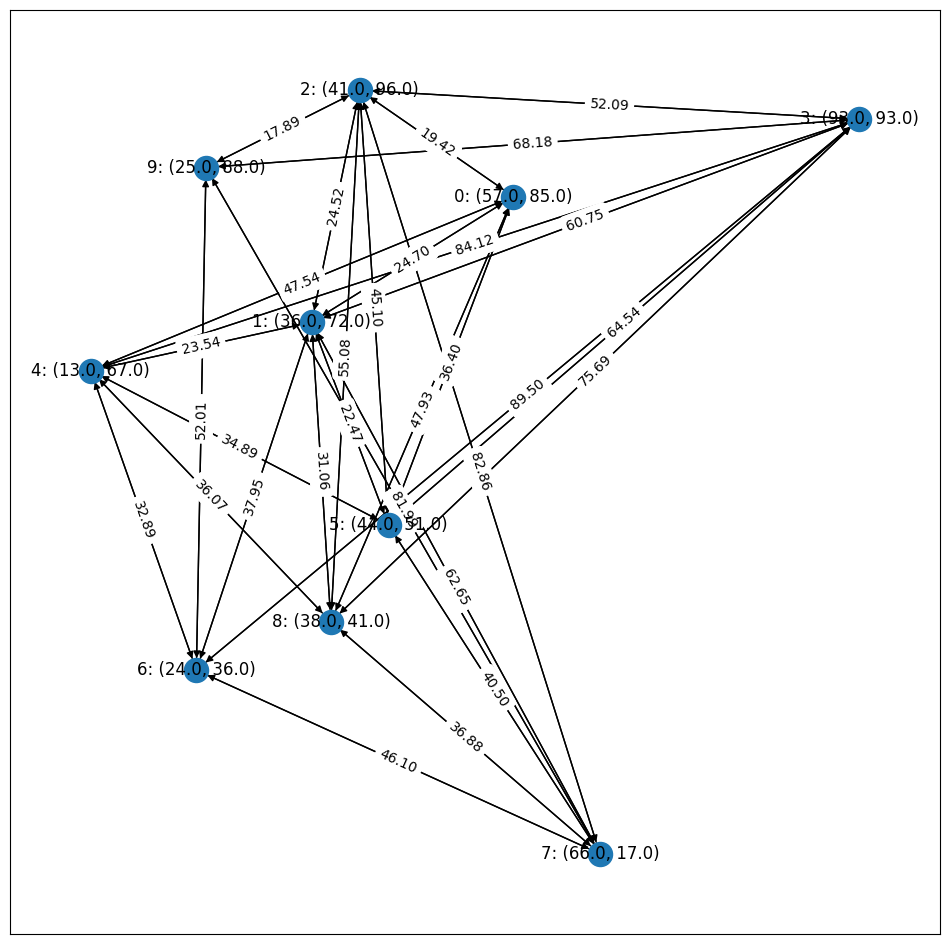

In [6]:
from tsp_gnn.utils.visual import show_graph_pos
show_graph_pos(test_graph)

In [30]:
from tsp_gnn.data.graph_generator import generate_datapoint

In [35]:
data, dist_matrix_t, nodes = generate_datapoint(10)

In [36]:
print(data.x.shape)
print(dist_matrix_t.shape)

torch.Size([10, 2])
torch.Size([10, 10])


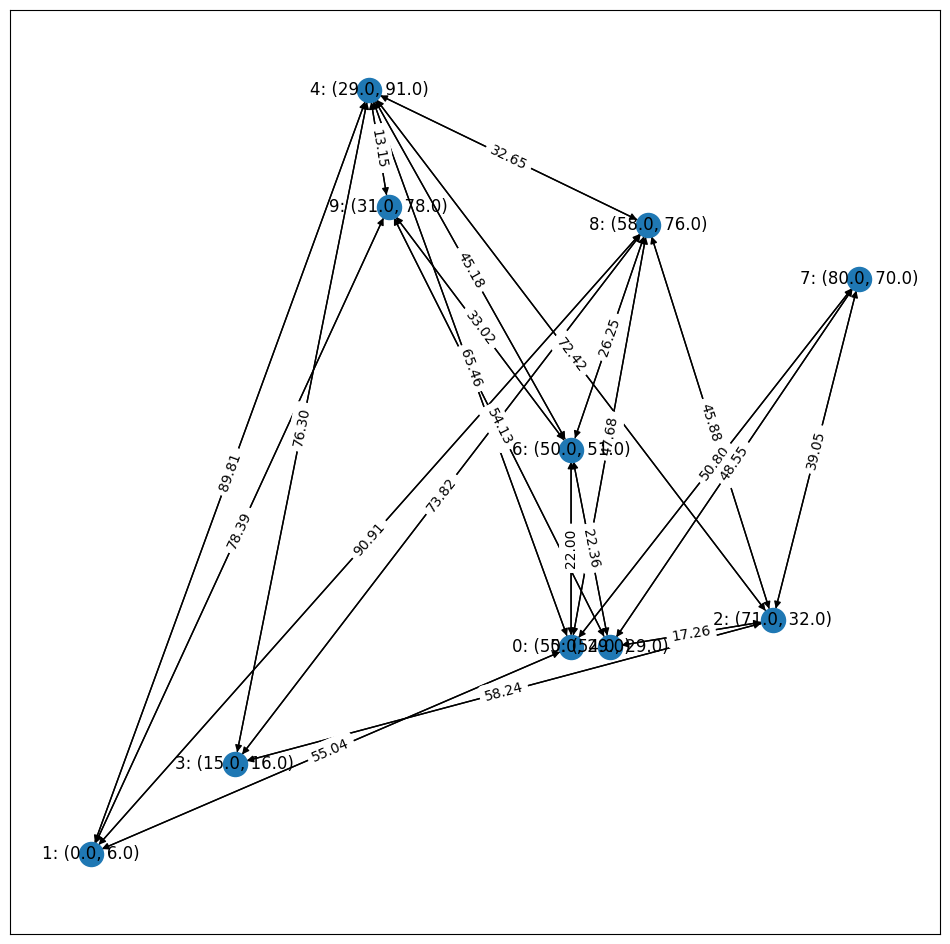

In [37]:
show_graph_pos(data)

In [38]:
import torch
import numpy as np
from python_tsp.exact import solve_tsp_dynamic_programminG

ans_nodes, dist = solve_tsp_dynamic_programming(dist_matrix_t.numpy())

In [39]:
mask_nodes = torch.full((data.num_nodes, ), False)
mask_nodes[ans_nodes] = True

In [41]:
from tsp_gnn.data.solver import dijkstra_path

In [43]:
ans_nodes

[0, 2, 1, 3, 6, 7, 4, 5, 8, 9]

In [42]:
path_edges, path_nodes = dijkstra_path(data, ans_nodes)
print(path_edges)
print(path_nodes)

0 2
[0, 7]
2 1
[2, 8]
1 3
[1, 8]
3 6
[3, 2, 5]
6 7
[6, 5]
7 4
[7, 2]
4 5
[4, 9]
5 8
[5, 6]
8 9
[8, 4]
[(7, 2), (0, 7), (8, 1), (2, 8), (8, 3), (1, 8), (5, 6), (2, 5), (3, 2), (5, 7), (6, 5), (2, 4), (7, 2), (9, 5), (4, 9), (6, 8), (5, 6), (4, 9), (8, 4)]
[0, 7, 2, 8, 1, 8, 3, 2, 5, 6, 5, 7, 2, 4, 9, 5, 6, 8, 4, 9]


In [44]:
node_mask = torch.tensor(path_nodes, dtype=torch.int32).unique()
data.x[node_mask]

tensor([[50., 29.],
        [ 0.,  6.],
        [71., 32.],
        [15., 16.],
        [29., 91.],
        [54., 29.],
        [50., 51.],
        [80., 70.],
        [58., 76.],
        [31., 78.]])

In [45]:
data.node_attrs()

['x', 'pos']

In [46]:
from torch_geometric.data import Data

In [47]:
label_graph = Data(x=data.x[node_mask], pos=data.x[node_mask], edge_index=path_edges, edge_weight=torch.ones(len(path_edges)))

In [180]:
label_graph.edge_index.t()

tensor([[7, 2],
        [0, 7],
        [8, 1],
        [2, 8],
        [8, 3],
        [1, 8],
        [5, 6],
        [2, 5],
        [3, 2],
        [5, 7],
        [6, 5],
        [2, 4],
        [7, 2],
        [9, 5],
        [4, 9],
        [6, 8],
        [5, 6],
        [4, 9],
        [8, 4]])

In [48]:
def convert_edge_index(graph):
    if isinstance(graph.edge_stores[0]['edge_index'], list):
        edge_index = torch.tensor(graph.edge_stores[0]['edge_index']).t().contiguous()
        graph.edge_stores[0]['edge_index'] = edge_index

convert_edge_index(label_graph)

In [49]:
label_graph.edge_stores

[{'x': tensor([[50., 29.],
         [ 0.,  6.],
         [71., 32.],
         [15., 16.],
         [29., 91.],
         [54., 29.],
         [50., 51.],
         [80., 70.],
         [58., 76.],
         [31., 78.]]), 'edge_index': tensor([[7, 0, 8, 2, 8, 1, 5, 2, 3, 5, 6, 2, 7, 9, 4, 6, 5, 4, 8],
         [2, 7, 1, 8, 3, 8, 6, 5, 2, 7, 5, 4, 2, 5, 9, 8, 6, 9, 4]]), 'pos': tensor([[50., 29.],
         [ 0.,  6.],
         [71., 32.],
         [15., 16.],
         [29., 91.],
         [54., 29.],
         [50., 51.],
         [80., 70.],
         [58., 76.],
         [31., 78.]]), 'edge_weight': tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1.])}]

In [50]:
from tsp_gnn.utils.visual import show_graph

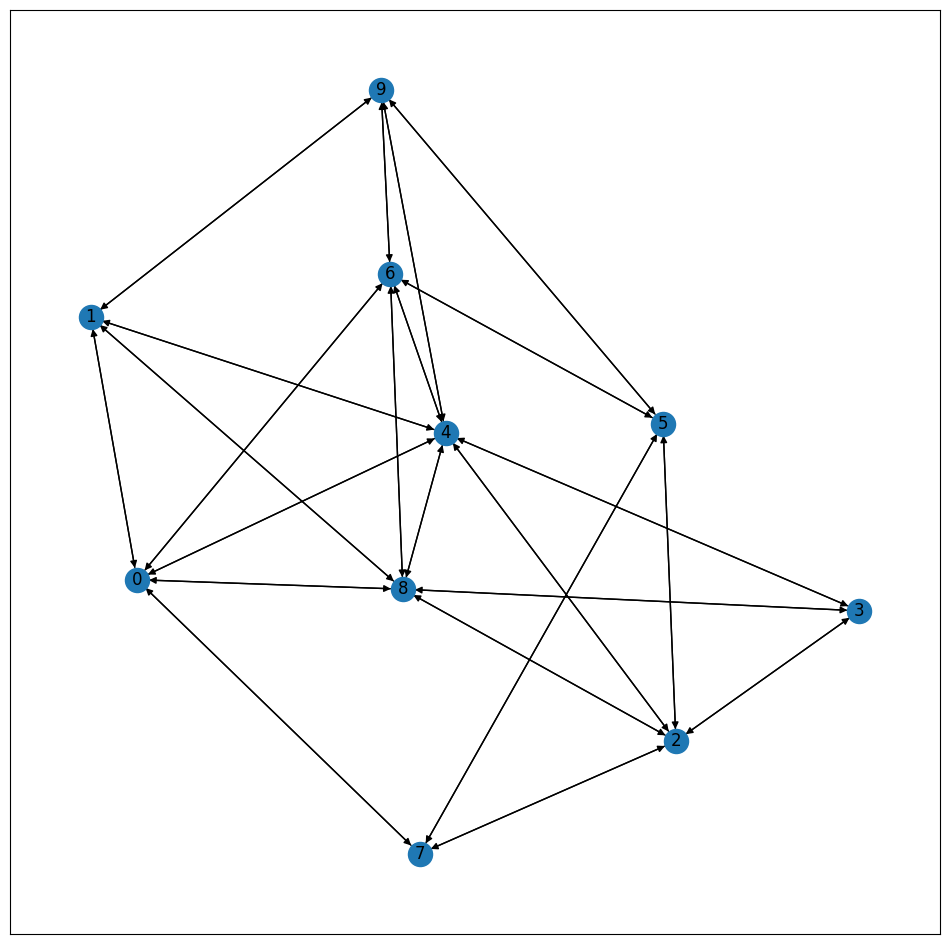

In [51]:
show_graph(data, edge_weight=False)

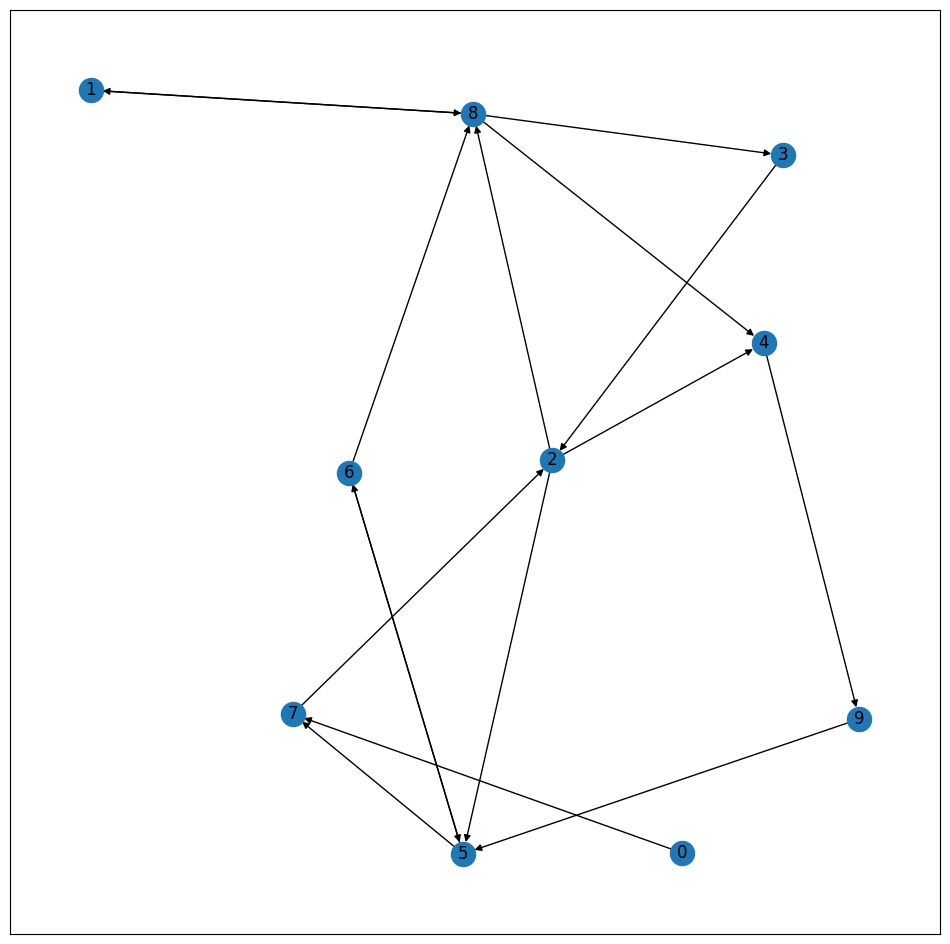

In [52]:
show_graph(label_graph)

In [181]:
x = data.x.unsqueeze(0)
dist_matrix = torch.tensor(dist_matrix_t, dtype=torch.float32).unsqueeze(0)

C:\Users\elmow\AppData\Local\Temp\ipykernel_33676\2155614725.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dist_matrix = torch.tensor(dist_matrix_t, dtype=torch.float32).unsqueeze(0)


In [182]:
print(x.shape, dist_matrix.shape)

torch.Size([1, 10, 2]) torch.Size([1, 10, 10])


In [183]:
config = {
    'num_node': 10,
    'node_dim': 2,
    'hidden_dim': 64,
    'voc_nodes_in': 10,
    'voc_nodes_out': 10,
    'voc_edges_in': 45,
    'voc_edges_out': 45,
    'num_layers': 3,
    'mlp_layers': 2,
    'aggregation': 'mean'
}

In [184]:
from tsp_gnn.models.gcn_model import ResidualGCNModel

In [185]:
model = ResidualGCNModel(config)

In [186]:
model(dist_matrix, x).shape

torch.Size([1, 10, 10, 10])